<hr style="height:3pt">

# Subspace Inference for Bayesian Neural Networks

Original paper: https://arxiv.org/pdf/1907.07504.pdf

Nick Stern | Phoebe Wong | Claire Stolz

AM207 Fall 2019, Harvard University

<hr style="height:3pt">

## Table of Contents

[1. Project Overview](#project_overview) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.1 Problem Statment](#problem_statement) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.2 Context](#context) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.3 Existing Work](#existing_work) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[1.4 Contribution](#contribution) <br>
[2. Technical Overview](#technical) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1 Subspaces](#subspaces)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2 Inference](#inference)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3 Experiments](#experiments)<br>
[3. Implementation](#implementation) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1 Walkthrough](#experiments)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2 Pressure Testing](#experiments)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.3 HW7 Regression](#experiments)<br>
[4. Discussion](#evaluation) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1 Reproducibility](#reproducibility)

<hr style="height:3pt">

<a id='project_overview'></a>
## 1. Project Overview

<hr style="height:3pt">

<a id='problem_statement'></a>
### 1.1 Problem Statement
Deep neural networks have become a state-of-the-art modeling technique in recent years. However, applying Bayesian inference methods to deep neural networks remains an issue due to their complex posteriors. This paper aims to address this problem by creating a low-dimensional subspace from the model parameters, greatly simplifying the posterior over which inference is performed. This leads to deep learning models with accurate predictions in addition to meaningful uncertainty estimates.

<a id='context'></a>
### 1.2 Context
Uncertainty quantification is vital in situations where the predictions have real life consequences. Bayesian inference is commonly used to incorporate uncertainty into modeling, as it provides an intuitive framework that weights observed data with one's prior belief about the generative process. However, one step of the inference process involves sampling model parameters, $\theta$, conditional on the observed data, $y$, from a probability distribution known as the **posterior**: $p(\theta | y)$. For simple models, such as a beta-binomial model of a coin flip, the posterior can be computed analytically and sampled from easily. As models get more complicated, inference is usually accomplished by either approximating the posterior (variational inference), or by using a more intricate sampling algorithm (MCMC samplers). Even these inference methods break down completely for neural networks with a few hidden layers. The numerous parameters that are layered and conjoined through repeated nonlinear functions give rise to a posterior that is most often hideously high-dimensional and extremely hard to sample from. With the success of deep learning applications in image recognition, language synthesis, and robotics, there is a profound need to develop ways to propagate Bayesian methods to larger and larger networks. 

<a id='existing_work'></a>
### 1.3 Existing Work

Most of the related work for this paper comes in two flavors:  1) sampling tools for BI or 2) methods of reducing the dimensionality of the model weights or dataset. One of the most important tools this paper utilizes is developed in a paper by Maddox et al. \[[1](#cit1)\],which presents the concept of stochastic weight averaging (SWA) with Gaussians (SWAG). Maddox et al. combine SWA  with an estimate of the covariance matrix of SGD iterates. The authors developed this approach because they noticed that SWA of SGD iterates formed a Gaussian-like posterior. Using SWAG, they were able to provide uncertainty estimates for a wide variety of problems, suggesting SWAG is a powerful tool for scalable and generalized predictions for network weights. Another important tool is the Eliptical Slice Sampler (ESS), which we discuss in more detail in later sections \[[2](#cit2)\]. 

Because of the significant academic and industrial interest in Bayesian inference, a number of recent papers have focused on improving the efficiency of such techniques. One idea the authors draw upon is in a paper by Silva and Kalaitzis \[[3](#cit3)\] who use Bayesian inference with projection methods, but apply their results to constrained latent variable models instead of BNNs. Silva and Kalaitzis first perform inference over unconstrained covariance matrices, then randomly sample the posterior and project the results in an optimized manner to parameters that lie in a constrained space. This can greatly reduce the computation costs of BI in this context, but is difficult to generalize to applications beyond probabilistic PCA. 

An even more similar approach is that of Pradier et al. \[[4](#cit4)\], who perform variational inference (VI) on BNN weights projected into a low-dimensional latent space. Izmailov et al. draw on this approach significantly in their implementation. They are able to improve the scalability of this approach by avoiding the training and fitting of multiple models (aside from ESS), which slow down the Pradier et al. implementation. 

Huggins et al. \[[5](#cit5)\] develop another method for dealing with computationally expensive Bayesian inference methods. Drawing from the discovery that only a small subset of the data must be used for each iteration of training, the authors develop what they call a "coreset." The coreset is a weighted representation of the full dataset. By representing the dataset as a coreset, the authors reduce the dataset size and increase efficiency. The coreset itself is easy to calculate, and the authors demonstrate the efficacy of this implementation on a synthetic Bayesian logistic regression model. However, the coreset works purely in the data space, and ignores dimesionality reduction that can be applied to the model weight space. This becomes particularly important when the network is large. This shortcoming motivates the authors' research on low-dimensional latent representations of neural network weight spaces. 

<a id='contribution'></a>
### 1.4 Authors' Contribution
The core idea that the authors are operating under is that the weight space of a deep neural network can be transformed into a low-dimensional latent representation that still captures the essence of the posterior. If this intuition is correct, then inference can be done efficiently in the low-dimensional subspace and transformed back into the original parameter space. The authors claim that they can reduce a 36 million dimensional network down to just 5 latent dimensions, and achieve similar results. In particular, the authors devise three types of subspaces, test out three different types of inference, and apply all combinations of these methods to three different problems ranging from simple regression to image classification. The paper boasts a massive reduction in computational cost from performing inference in a subspace, while maintaining model accuracy and rational uncertainty bounds. 

<hr style="height:3pt">

<a id='technical'></a>
## 2. Technical Overview 

<hr style="height:3pt">

<a id='subspaces'></a>
### 2.1 Subspaces 
A $K$-dimensional subspace is defined as a transformation from a set of $K$ latent vectors, ${z_1, ..., z_K}$, to the original, $d$-dimensional weight space through a transformation matrix, $P \in \mathbb{R}^{d x K}$, and a shift vector, $\hat{w}$. The authors design 3 subspaces on which to perform subspace inference (SI):


1. **Random subspace:** constructed by sampling rows of $P$ from a multivariate Normal distribution: $p_1,...,p_K \sim \mathcal{N}(0,I_K)$. The shift vector, $\hat{w}$, was generated through Stocahstic Weight AveraGing (SWAG), where model weights across successive SGD iterations are averaged together: $\hat{w} = \frac{1}{M} \sum_i^M w_i$. The SGD is performed on a trained model with a high learning rate, under the intuition that the loss surface resembles the posterior.

2. **PCA-based subspace:** formed from a PCA decomposition of the matrix, $A$, of devations from the average model weights for successive SGD iterations. $P$ was then constructed from the first $K$ principle components. The weight vector $\hat{w}$ is computed equivalently to the random subspace. The authors note there is a connection between the PCA decomposition and the eigenvalues of the Hessian of the loss.

3. **Curve subspace:** based on 2-dimensional paths in the weight space that connect SGD solutions produced from different initializations. These paths have a high posterior density and perform well in this context. However, because the networks must be retrained with different initial conditions (with high computation demands), we chose not to implement this subspace. 

<a id='inference'></a>
### 2.2 Inference
The authors use 3 different approximate posterior inference methods to evaluate their subspaces: No U-Turn Sampler (NUTS), elliptical slice sampling (ESS), and Variational Inference with fully factorized Gaussian approximation family (VI) and Real-valued Non-Volume Preserving flow (RealNVP).

1. **NUTS** is an adaptation the HMC algorithm that removes the necessity of selecting the number of steps by recursively generating candidate points, and stopping when the algorithm starts to double-back on its steps. It is at least as computationally efficient as a well-tuned HMC sampler.

2. **ESS** is another MCMC algorithm that reduces the number of free parameters. ESS works by using an adaptive step size. Essentially, the authors of the ESS algorithm observe that sampling from $p(x|y)$ and $p(y|x)$ is typically much easier than sampling from the full distribution, $\pi$. In particular, ESS samples from posteriors over latent variables with the form: $\pi(x) \propto L(x) \mathcal(N)(x; \mu, \Sigma)$, where $L$ is a likelihood function, and $\mathcal(N)(x; \mu, \Sigma)$ is a multivariate Gaussian (MVG) prior. ESS uses the invariance property of the MVG to sample. 

3. Density estimation using **RealNVP** uses a change of variables procedure to compute the log-likelihood on continuous data. The authors use a class of bijective functions that perform well for this purpose, especially for deep networks and batch normalization.

<a id='experiments'></a>
### 2.3 Experiments

In total, the authors ran 3 main experiments to test out various combinations of their subspaces and inference methods:

1. Experiment 1 involved generating **synthetic data** with gaps, and then testing out how subspace inference was able to characterize the predictive posterior uncertainty in regions with missing data. The authors compared inference in the subspace with inference in the original weight space to note the effectiveness of the subspace.
    
2. As a second experiment, the authors test out how subspace inference works on regression tasks using five datasets from the **UCI machine learning repository** (https://archive.ics.uci.edu/ml/datasets.php). They found that subspace inference methods perform similarly in accuracy and log-likelihood to non-Bayesian neural networks with the same architectures. 
    
3. The authors tested their methods on state-of-the-art CNN on **CIFAR datasets**. They used five-dimensional random and PCA subspaces around a trained stochastic weight averaging (SWA) solution (with temperature = 5000), as well as a two-dimensional curve subspace (temperature = 10000). Results suggested the accuracy and negative log-likelihood improved, going from random, to PCA and to curve subspaces. They used the PCA subspace for the remaining experiments because of the good performance with a much lower computational cost. 

<hr style="height:3pt">

<a id='implementation'></a>
## 3. Implementation 

<hr style="height:3pt">

<a id='implementation'></a>
### 3.1 Walkthrough
In the following section we will walk through our implementation of the paper. We chose to implement the random and PCA subspaces on the synthetic regression problem in the paper, partially for the computational ease, and partially because we anticipated the PCA subspace would be demonstrably better than the random subspace and showcase the impact. Furthermore, we endeavored to implement ESS sampling, out of interest for learning more about it and acknowledging that it requires less parameter tuning.

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import get_criterion, decay_lr, plot_predictive, preload_our_model, preload_author_model, \
                    unflatten_like, set_model_weights
from inference import SWAG, ESS
from subspaces import RandomSubspace, PCASubspace
from tqdm.notebook import tqdm
sns.set()

<a id='Part1'></a>
### Setting up the regression problem

We first replicated the feature generation process using synthesized data from the authors' github. The data are 1D, with a single $x$ and $y$. The two features used in the network were: $x/2$ and $(x/2)^2$.

In [2]:
# Load in data to train MLP
data = np.load('data/data.npy')
x, y = data[:, 0], data[:, 1]

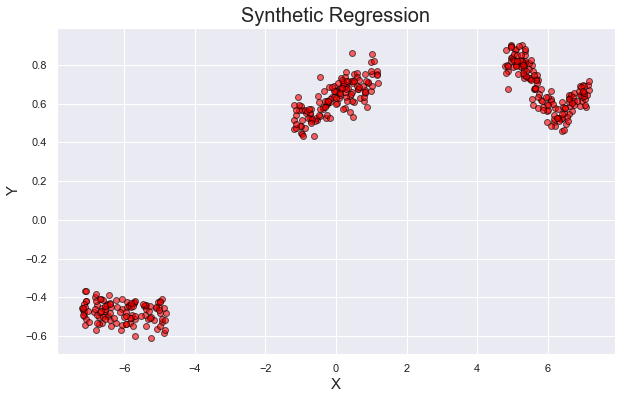

In [3]:
# Visualize data
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x, y, facecolor='red', edgecolor='black', alpha=.6)
ax.set_title('Synthetic Regression', fontsize=20)
ax.set_xlabel('X', fontsize=15)
ax.set_ylabel('Y', fontsize=15);

Each of the subspace construction methods operate on a network with pre-trained weights. For the synthetic regression dataset, the authors use a fully connected network with 4 hidden layers that have [200, 50, 50, 50] neurons respectively. We recreate this network using pytorch as a backend.

In [4]:
# Define MLP in pytorch
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 200)    # hidden layer 1
        self.fc2 = nn.Linear(200, 50)   # hidden layer 2
        self.fc3 = nn.Linear(50, 50)    # hidden layer 3
        self.fc4 = nn.Linear(50, 50)    # hidden layer 4
        self.output = nn.Linear(50, 1)  # output layer
        
    def forward(self, x):
        x = self.fc1(x).relu()
        x = self.fc2(x).relu()
        x = self.fc3(x).relu()
        x = self.fc4(x).relu()

        return self.output(x)

The authors define their loss function to be "Minus Gaussian Likelihood" which is just MSE / $2\sigma^2$. We implemented this, in addition to optionally use MSE as the loss, as they are equal to within a factor of $1$ / $2\sigma^2$.

In [5]:
# Prepare data
features = lambda x: np.hstack([x[:, None] / 2.0, (x[:, None] / 2.0) ** 2])
y = y.reshape(-1, 1)
f = features(x)   # features are: x/2, (x/2)^2
dataset = TensorDataset(torch.from_numpy(f.astype(np.float32)), torch.from_numpy(y.astype(np.float32)))
dataloader = DataLoader(dataset, batch_size=50, shuffle=True)

# Define loss function
criterion = get_criterion(loss='NLL')

In [6]:
# Run the training loop on the data
def train_model(model, dataloader, optimizer, criterion, epochs=3000, print_freq=1000, decay=True):
    model.train() # prep model layers for training
    
    for epoch in tqdm(range(epochs)):
        epoch_loss = 0
        
        # Implementation of learning rate decay from paper
        epoch_ratio = (epoch + 1) / epochs
        if decay:
            lr = decay_lr(optimizer, epoch_ratio)
        else:
            lr = optimizer.defaults['lr']
        
        for inputs, labels in dataloader:
            optimizer.zero_grad()  # clear gradients
            
            preds = model(inputs)  # perform a forward pass
            loss = criterion(preds, labels)  # compute the loss

            loss.backward()   # backpropagate
            optimizer.step()  # update the weights

            epoch_loss += loss.data.item()*inputs.shape[0]
            
        # Print output
        if (epoch % print_freq == 0 or epoch == epochs - 1):
            print('Epoch %d | LR: %g | Loss: %.4f' % (epoch, lr, epoch_loss))

### Bootstrap Example
As the authors did, we boostrapped 5 MLE models together to get an intuition for what the uncertainty interval should roughly look like when we perform Bayesian inference. 

In [7]:
# Train 5 separate models
for i in tqdm(range(5)):
    model = MLP()
    # Define optimizer as SGD w/ high momentum
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=.95)
#     train_model(model, dataloader, optimizer, criterion)
#     torch.save(model.state_dict(), "model_weights/bootstrap_model{}.pt".format(i+1))

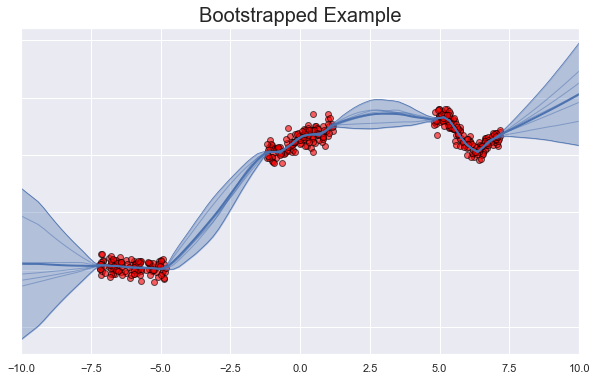

In [8]:
# Load in boostrapped models and visualize
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))

trajectories = []
for i in range(5):
    model.load_state_dict(torch.load("model_weights/bootstrap_model{}.pt".format(i+1)))
    out = model(inp).detach().numpy().T
    trajectories.append(out)
trajectories = np.vstack(trajectories)
plot_predictive(data, trajectories, z, title="Bootstrapped Example", save_path='images/boostrap_example.png');

Here, we can see that there is greater uncertainty in regions where we lack data. This is known as Epistemic uncertainty. We expect to see similar behavior when we perform subspace inference.

### A Note on SWAG

In order to get the parameters, $P$ and $\hat{w}$, with which to initialize our subspaces, we needed to write a method that performs Stochastic Weight Averaging (SWAG). SWAG is a method for approximating the posterior of a BNN using the SGD iterates (https://arxiv.org/pdf/1902.02476.pdf). The algorithm was originally intended to be a form of variational inference that uses first two moments (mean, covariance) from the SGD iterates to initialize a Gaussian. For our purposes, we use the mean as $\hat{w}$, for both the random and PCA subspaces, and the matrix of deviations, $A$, for the PCA subspace implementation. 

Our implementation of SWAG can be found in ```inference.py```. 

### A Note on ESS

Link to the ESS paper: http://proceedings.mlr.press/v9/murray10a/murray10a.pdf 

ESS assumes a multivariate Gaussian prior for the subspace elements, $z$, but we need to feed in the likelihood. Assuming the response variable is Normally distributed about our neural network prediction with some variance, $\sigma^2$, we can express the likelihood as follows:

$$
\mathcal{L} = \prod^N_{n=1}p(Y^{(n)} |\mathbf{X}^{(n)} , \mathbf{W})
$$

$$
p(Y^{(n)} |\mathbf{X}^{(n)} , \mathbf{W}) = \left(2\pi\sigma^2\right)^{-\frac{1}{2}}\text{exp}\left[-\frac{\left(Y^{(n)} - g_{\mathbf{W}}\left(\mathbf{X}^{(n)}\right)\right)^2}{2\sigma^2}\right]
$$

Taking the log of the above expression yields:

$$
\begin{aligned}
\log(\mathcal{L}) &= \sum_{n=1}^N -\frac{1}{2}\log\left(2\pi\sigma^2\right) -\frac{\left(Y^{(n)} - g_{\mathbf{W}}\left(\mathbf{X}^{(n)}\right)\right)^2}{2\sigma^2} \\
&= -\frac{N}{2}\log\left(2\pi\sigma^2\right) - \sum_{n=1}^N \frac{\left(Y^{(n)} - g_{\mathbf{W}}\left(\mathbf{X}^{(n)}\right)\right)^2}{2\sigma^2}
\end{aligned}
$$

In ESS, a Metropolis-Hastings step is taken to compare the log likelihood for a proposed sample with the current sample. As such, the constant in the above expression cancels out, leaving us with simply:

$$
\boxed{\frac{\text{-SSE}}{2\sigma^2}}
$$

We also temper the above likelihood by a factor of $\frac{1}{T}$ as discussed in the paper. Our implementation of ESS is partially pulled from the python implementation used by the authors, though we wrote our own interface to work with it in a much cleaner way. The ESS function can be found in ```inference.py```.

Note, the way the authors performed ESS sampling was to generate a matrix of sampled weights, and then randomly select a subset of 10%. This is slightly different from the thinning and burning we've done in class, but in the pursuit of reproducibility, we adopted their style in stride.

### Inference w/ ESS & Random Subspace

We wrote a random subspace class from scratch that is located in ```subspaces.py```. It calls our SWAG function to initialize the shift vector, $\hat{w}$. As the model training that occurs during SWAG is a stochastic process, we've saved the model weights and the shift vector in the file ```model_weights/random_model.pt```. By default, these weights are read into the random subspace class upon instatiation.

In [9]:
preloaded = preload_our_model(path='model_weights/random_model.pt')
model = MLP()
criterion = get_criterion(loss='NLL')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=.95)
model_info = {'model': model, 'dataloader': dataloader, 'optimizer': optimizer, 'criterion': criterion}
rs = RandomSubspace(model_info, preloaded=preloaded)

Loading pretrained random weights...


In [10]:
# Initialize parameters
T = .15
noise_var = .05
num_samples = 1000

random_ess = ESS(rs, num_samples=num_samples, T=T, noise_var=noise_var)  # initialize sampler with subspace

  0%|          | 2/1000 [00:00<01:23, 11.99it/s]

Initializing 1000 samples...


100%|██████████| 1000/1000 [01:20<00:00, 12.50it/s]


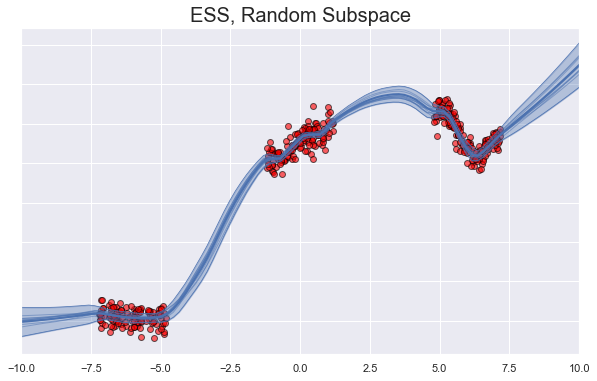

In [11]:
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))
model = rs.model_info['model']  # pull model from subspace

trajectories = []
for i in range(100):
    # Sample weights using ESS
    weights = random_ess.sample()
    
    # Set model weights
    set_model_weights(model, weights)
    out = model(inp)
    
    trajectories.append(out.detach().numpy().ravel())

trajectories = np.vstack(trajectories)    
plot_predictive(data, trajectories, z, title="ESS, Random Subspace", save_path='images/random_subspace.png')

With the authors' default parameters for the temperature, $T = .15$, the variance of the response variable, $\sigma_y = .05$, and the variance of the prior for the ESS parameter, $\sigma_{\nu} = 1$, we see that the random subspace doesn't really capture the epistemic uncertainty in the same way that the boostrapped example does. The uncertainty interval isn't nearly as wide in areas where we have no data at all, and is not as narrow in areas where we do have data. This matches very closely with what the authors observed.

### Inference w/ ESS & PCA subspace

We wrote a PCA subspace class from scratch that is located in ```subspaces.py```. It calls our SWAG function to initialize both the shift vector, $\hat{w}$, and the transformation matrix, $P$. As the model training that occurs during SWAG is a stochastic process, we've saved the model weights, shift vector, and transformation matrix in the file ```model_weights/pca_model.pt```. By default, these weights are read into the PCA subspace class upon instatiation.

In [12]:
# Initialize PCA subspace
preloaded = preload_our_model(path='model_weights/pca_model.pt')
model = MLP()
criterion = get_criterion(loss='NLL')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=.95)
model_info = {'model': model, 'dataloader': dataloader, 'optimizer': optimizer, 'criterion': criterion}
pca_subspace = PCASubspace(model_info, preloaded=preloaded)

Loading pretrained PCA weights...


In [13]:
# Initialize parameters
num_samples = 1000
T = 1.5
noise_var = .05
nu_scale = 25

ess_pca = ESS(pca_subspace, num_samples=num_samples, T=T, noise_var=noise_var, nu_scale=nu_scale) 

  0%|          | 2/1000 [00:00<00:52, 19.05it/s]

Initializing 1000 samples...


100%|██████████| 1000/1000 [00:30<00:00, 33.15it/s]


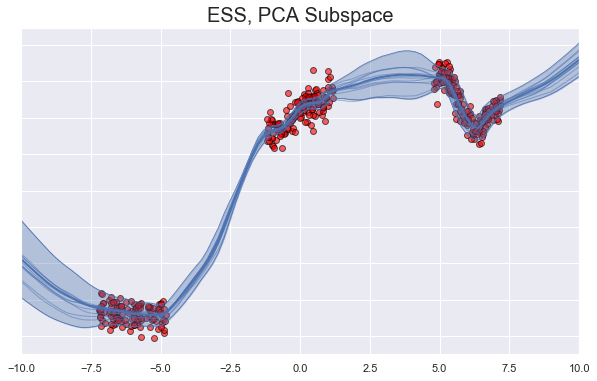

In [14]:
# Perform ESS sampling
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))
model = pca_subspace.model_info['model']  # pull model from subspace

pca_trajectories = []
for i in range(100):
    # Sample weights using ESS
    weights = ess_pca.sample()
    
    # Set model weights
    set_model_weights(model, weights)
    out = model(inp)
    
    pca_trajectories.append(out.detach().numpy().ravel())

pca_trajectories = np.vstack(pca_trajectories)    
plot_predictive(data, pca_trajectories, z, title="ESS, PCA Subspace", save_path='images/pca_subspace.png')

With the authors' default parameters for the temperature, $T = 1.5$, the variance of the response variable, $\sigma_y = .05$, and the variance of the prior for the ESS parameter, $\sigma_{\nu} = 25$, we see that the PCA subspace is much better at capturing the epistemic uncertainty in the same way that the boostrapped example does. The uncertainty interval is wide in areas where we have no data at all, however, it is still not as narrow in areas where we do have data, and is actually wider than the random subspace implementation. While this feels like only a partial success, this does match very closely with what we were able to generate with the authors' implemenation.

Ultimately - **the authors' implemenation did not closely match what they reported in their paper**! We talk about this further in our discussion section.

<a id='implementation'></a>
### 3.2 Pressure Testing
We were interested to see how sensitive the subspace inference would be to varying some of the parameters. We honed in on pressure testing the temperature, $T$, and the prior variance, $\sigma_{\nu}$, as these were parameters the authors changed between the random subspace and the PCA subspace, and it wasn't intuitive to us what they should be initially. 

### Temperature

Note - it takes a while to perform inference for both subspaces across 4 different temperatures. You can instead check out the results at ```images/temperature.png```.

In [15]:
# Initialize input
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))

# Initialize parameters
noise_var = .05
num_samples = 1000
alltemp = [0.0001, 0.15, 1.5, 10]

random_traj_all, pca_traj_all = [], []
for T in tqdm(alltemp):
    # initialize samplers with subspaces
    random_ess = ESS(rs, num_samples=num_samples, T=T, noise_var=noise_var)  
    pca_ess = ESS(pca_subspace, num_samples=num_samples, T=T, noise_var=noise_var, nu_scale=25)

    # pull models from subspaces
    random_model = rs.model_info['model']  
    pca_model = pca_subspace.model_info['model']

    random_traj, pca_traj = [], []
    for i in range(100):
        # Sample weights using ESS
        random_weights = random_ess.sample()
        pca_weights = pca_ess.sample()

        # Set model weights
        set_model_weights(random_model, random_weights)
        set_model_weights(pca_model, pca_weights)
        
        # Forward pass
        random_out = random_model(inp)
        pca_out = pca_model(inp)
        
        # Save results
        random_traj.append(random_out.detach().numpy().ravel())
        pca_traj.append(pca_out.detach().numpy().ravel())

    random_traj = np.vstack(random_traj)   
    random_traj_all.append(random_traj)
    
    pca_traj = np.vstack(pca_traj)   
    pca_traj_all.append(pca_traj)

  0%|          | 1/1000 [00:00<02:23,  6.95it/s]

Initializing 1000 samples...


  0%|          | 1/1000 [00:00<01:42,  9.75it/s]

Initializing 1000 samples...


  0%|          | 1/1000 [00:00<01:59,  8.33it/s]

Initializing 1000 samples...


  0%|          | 3/1000 [00:00<00:52, 19.14it/s]

Initializing 1000 samples...


  0%|          | 2/1000 [00:00<00:58, 16.92it/s]

Initializing 1000 samples...


  0%|          | 1/1000 [00:00<02:55,  5.69it/s]

Initializing 1000 samples...


  0%|          | 4/1000 [00:00<00:29, 34.09it/s]

Initializing 1000 samples...


  0%|          | 2/1000 [00:00<00:50, 19.83it/s]

Initializing 1000 samples...


100%|██████████| 1000/1000 [00:19<00:00, 52.38it/s]


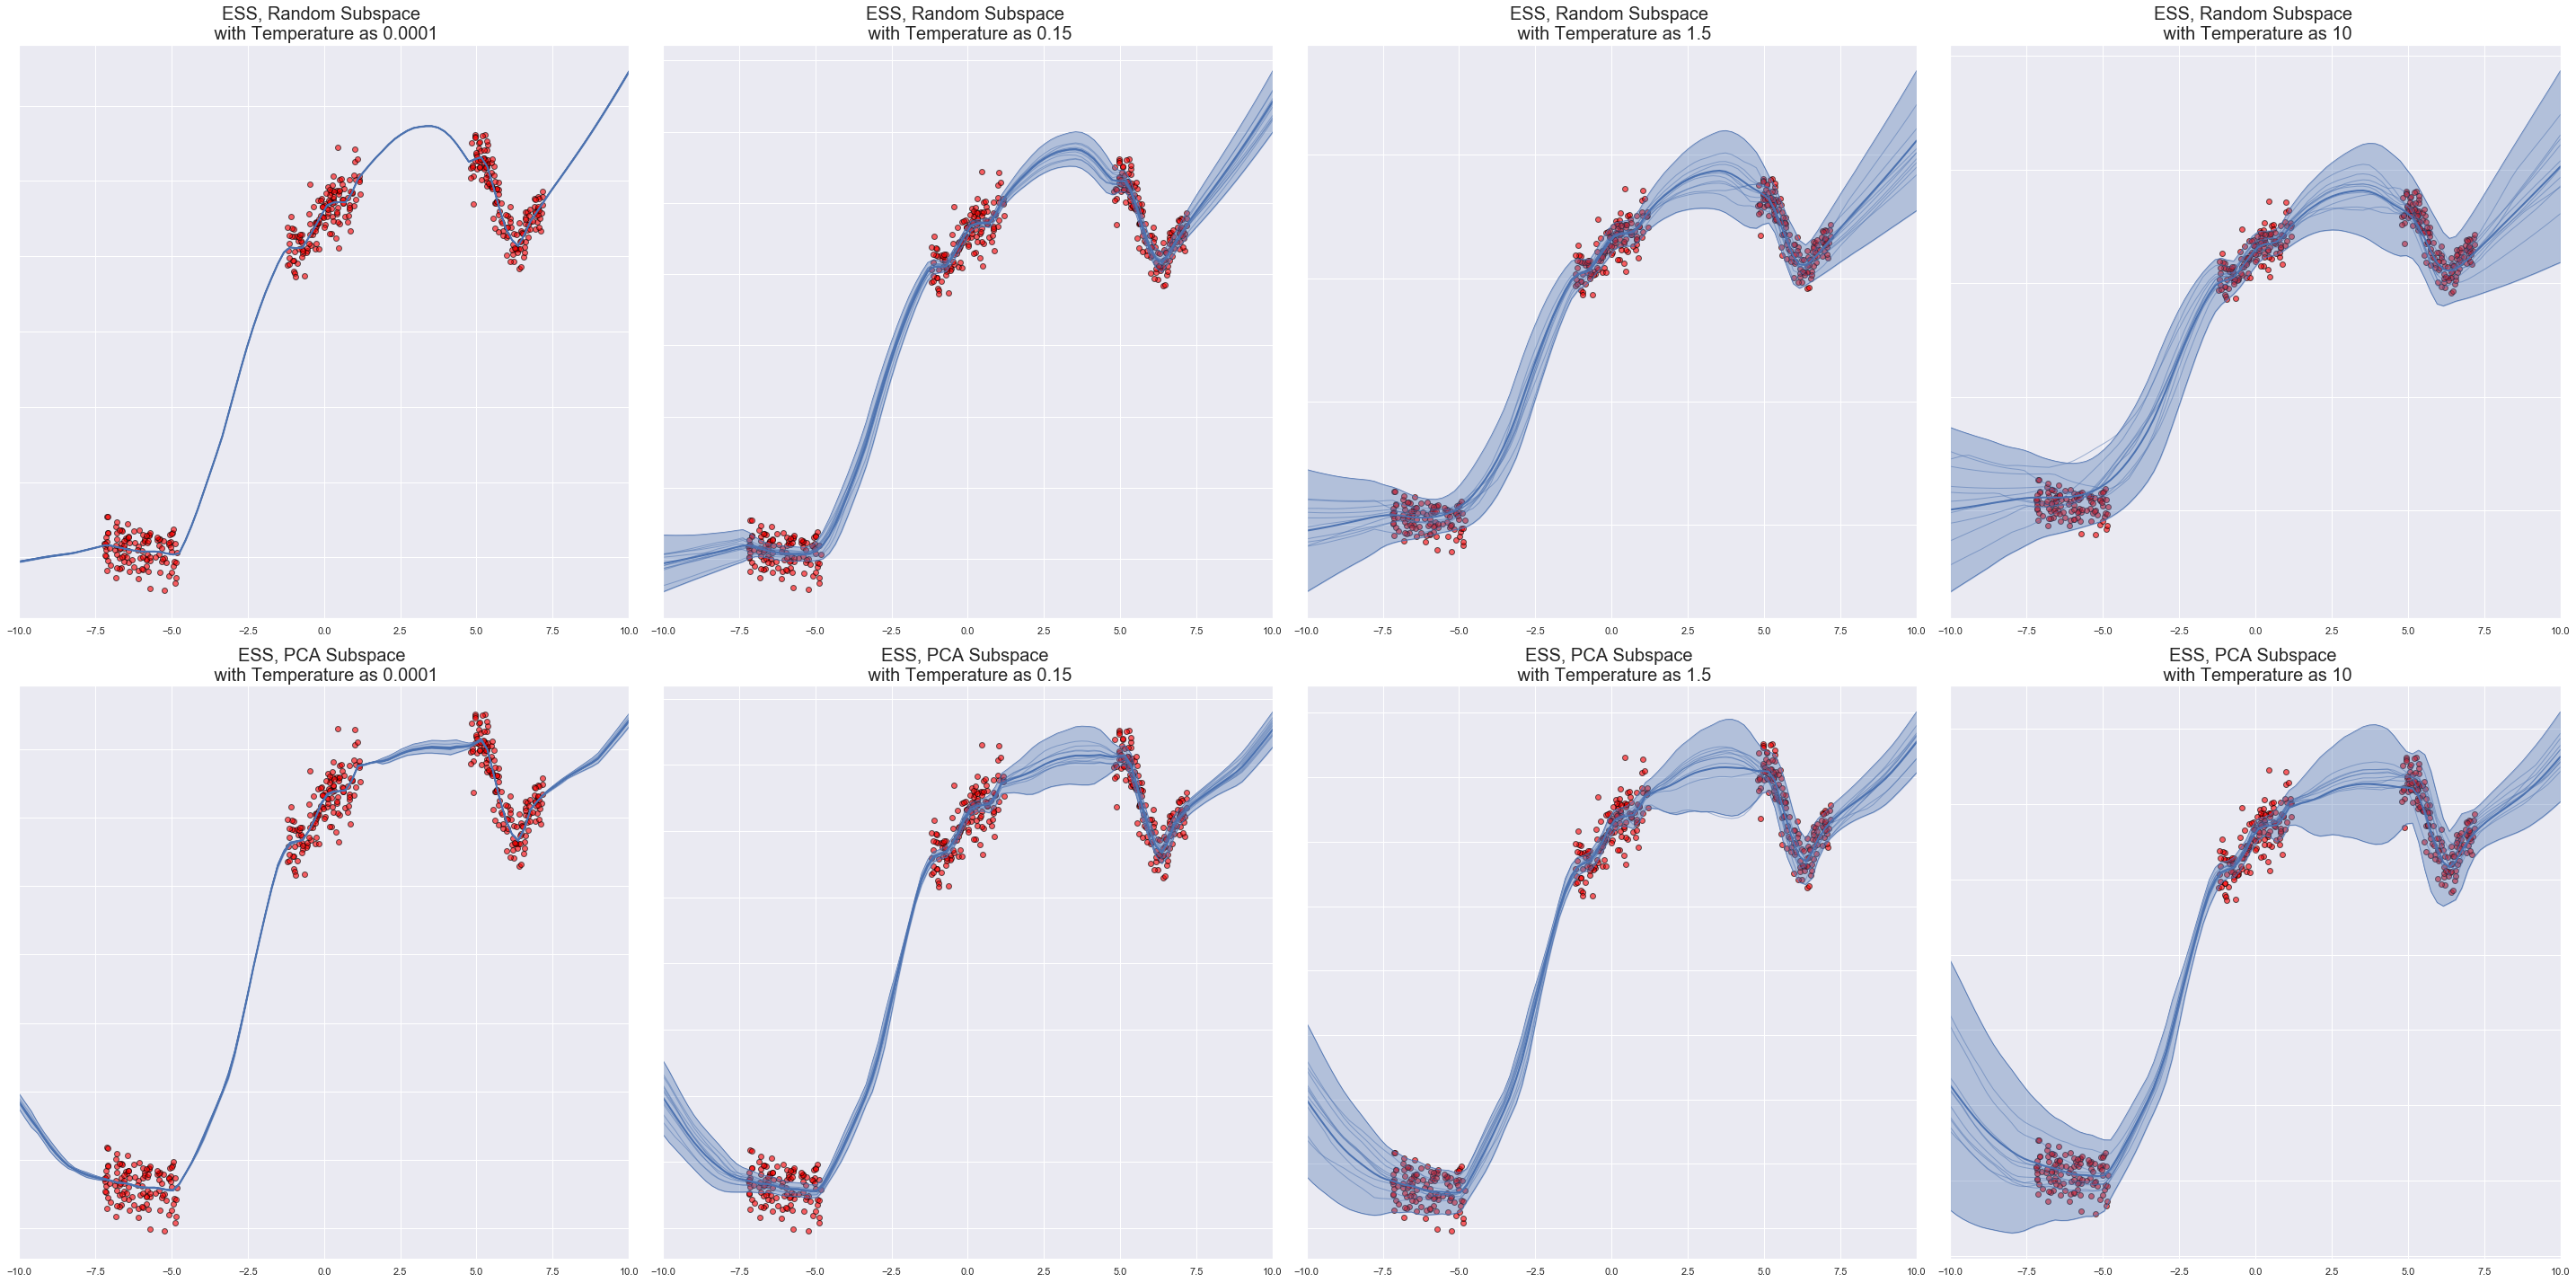

In [16]:
## Putting the plots together for random vs PCA subspace
title = "ESS, {} Subspace \n with Temperature as {}"
fig, ax = plt.subplots(2, 4, figsize = (40,20))
for ix, T in enumerate(alltemp):
    plot_predictive(data, random_traj_all[ix], z, title=title.format('Random', T), ax=ax[0,ix])
    plot_predictive(data, pca_traj_all[ix], z, title=title.format('PCA', T), ax=ax[1,ix])

fig.tight_layout()
# fig.savefig('images/temperature.png')

As the authors discussed in the paper, when $K << N$ where $N$ is the number of datapoints, the posterior can overly concentrate around the MLE and lead to "overconfident uncertainty estimates." As a result, they "temper" the likelihood, $p(y|z)$, by a power of $T^{-1}$, such that the posterior can be expressed as:

$p_T(z|y) \propto p(y|z)^{1/T} p(z)$

With the tempered likelihood, when $T = 1$ the true posterior is recovered. As $T \rightarrow \infty$, the posterior approaches the prior.

We can see for both random subspace and PCA subspace, with a higher temperature, there is a wider uncertainty (3$\sigma$ interval) around the prediction. Using the temperatures chosen by the authors for the two subspaces (0.15 for random subspace and 1.5 for PCA subspace), we do see a discrepancy in the width of the uncertainty interval. Namely, the PCA subspace appears to capture the increase in uncertainty better around $1.2 < x < 4.5$ where there is no data. However, this discrepancy all but vanishes when comparing the two subspaces for equal temperatures, which calls into question the efficacy of the PCA method. 

Supposedly the authors chose the temperature through cross validation, though they don't elaborate on exactly what metric they used to do so for this synthetic regression dataset. Tempering the likelihood separately for the two different subspace methods, given the model has the same number of parameters, feels somewhat arbitrary to us.

### Nu Prior Covariance Factor

Note - it takes a while to perform inference for both subspaces across 4 different temperatures. You can instead check out the result in ```images/nu_scale.png```.

In [17]:
# Initialize input
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(features(z).astype(np.float32))

# Initialize parameters
noise_var = .05
num_samples = 1000
all_nu_scale = [1, 25, 100, 10000]
random_traj_all_nu, pca_traj_all_nu = [], []

for nu_scale in tqdm(all_nu_scale):
    # initialize samplers with subspaces
    random_ess = ESS(rs, num_samples=num_samples, T=.15, noise_var=noise_var, nu_scale=nu_scale)  
    pca_ess = ESS(pca_subspace, num_samples=num_samples, T=1.5, noise_var=noise_var, nu_scale=nu_scale)

    # pull models from subspaces
    random_model = rs.model_info['model']  
    pca_model = pca_subspace.model_info['model']

    random_traj, pca_traj = [], []
    for i in range(100):
        # Sample weights using ESS
        random_weights = random_ess.sample()
        pca_weights = pca_ess.sample()

        # Set model weights
        set_model_weights(random_model, random_weights)
        set_model_weights(pca_model, pca_weights)
        
        # Forward pass
        random_out = random_model(inp)
        pca_out = pca_model(inp)
        
        # Save results
        random_traj.append(random_out.detach().numpy().ravel())
        pca_traj.append(pca_out.detach().numpy().ravel())

    random_traj = np.vstack(random_traj)   
    random_traj_all_nu.append(random_traj)
    
    pca_traj = np.vstack(pca_traj)   
    pca_traj_all_nu.append(pca_traj)

  0%|          | 0/1000 [00:00<?, ?it/s]

Initializing 1000 samples...


  1%|          | 6/1000 [00:00<00:18, 54.80it/s]

Initializing 1000 samples...


  0%|          | 1/1000 [00:00<02:05,  7.97it/s]

Initializing 1000 samples...


  0%|          | 5/1000 [00:00<00:27, 36.30it/s]

Initializing 1000 samples...


  0%|          | 2/1000 [00:00<01:01, 16.27it/s]

Initializing 1000 samples...


  0%|          | 1/1000 [00:00<01:40,  9.92it/s]

Initializing 1000 samples...


  0%|          | 1/1000 [00:00<02:07,  7.84it/s]

Initializing 1000 samples...


  0%|          | 1/1000 [00:00<02:29,  6.70it/s]

Initializing 1000 samples...


100%|██████████| 1000/1000 [01:39<00:00, 10.03it/s]


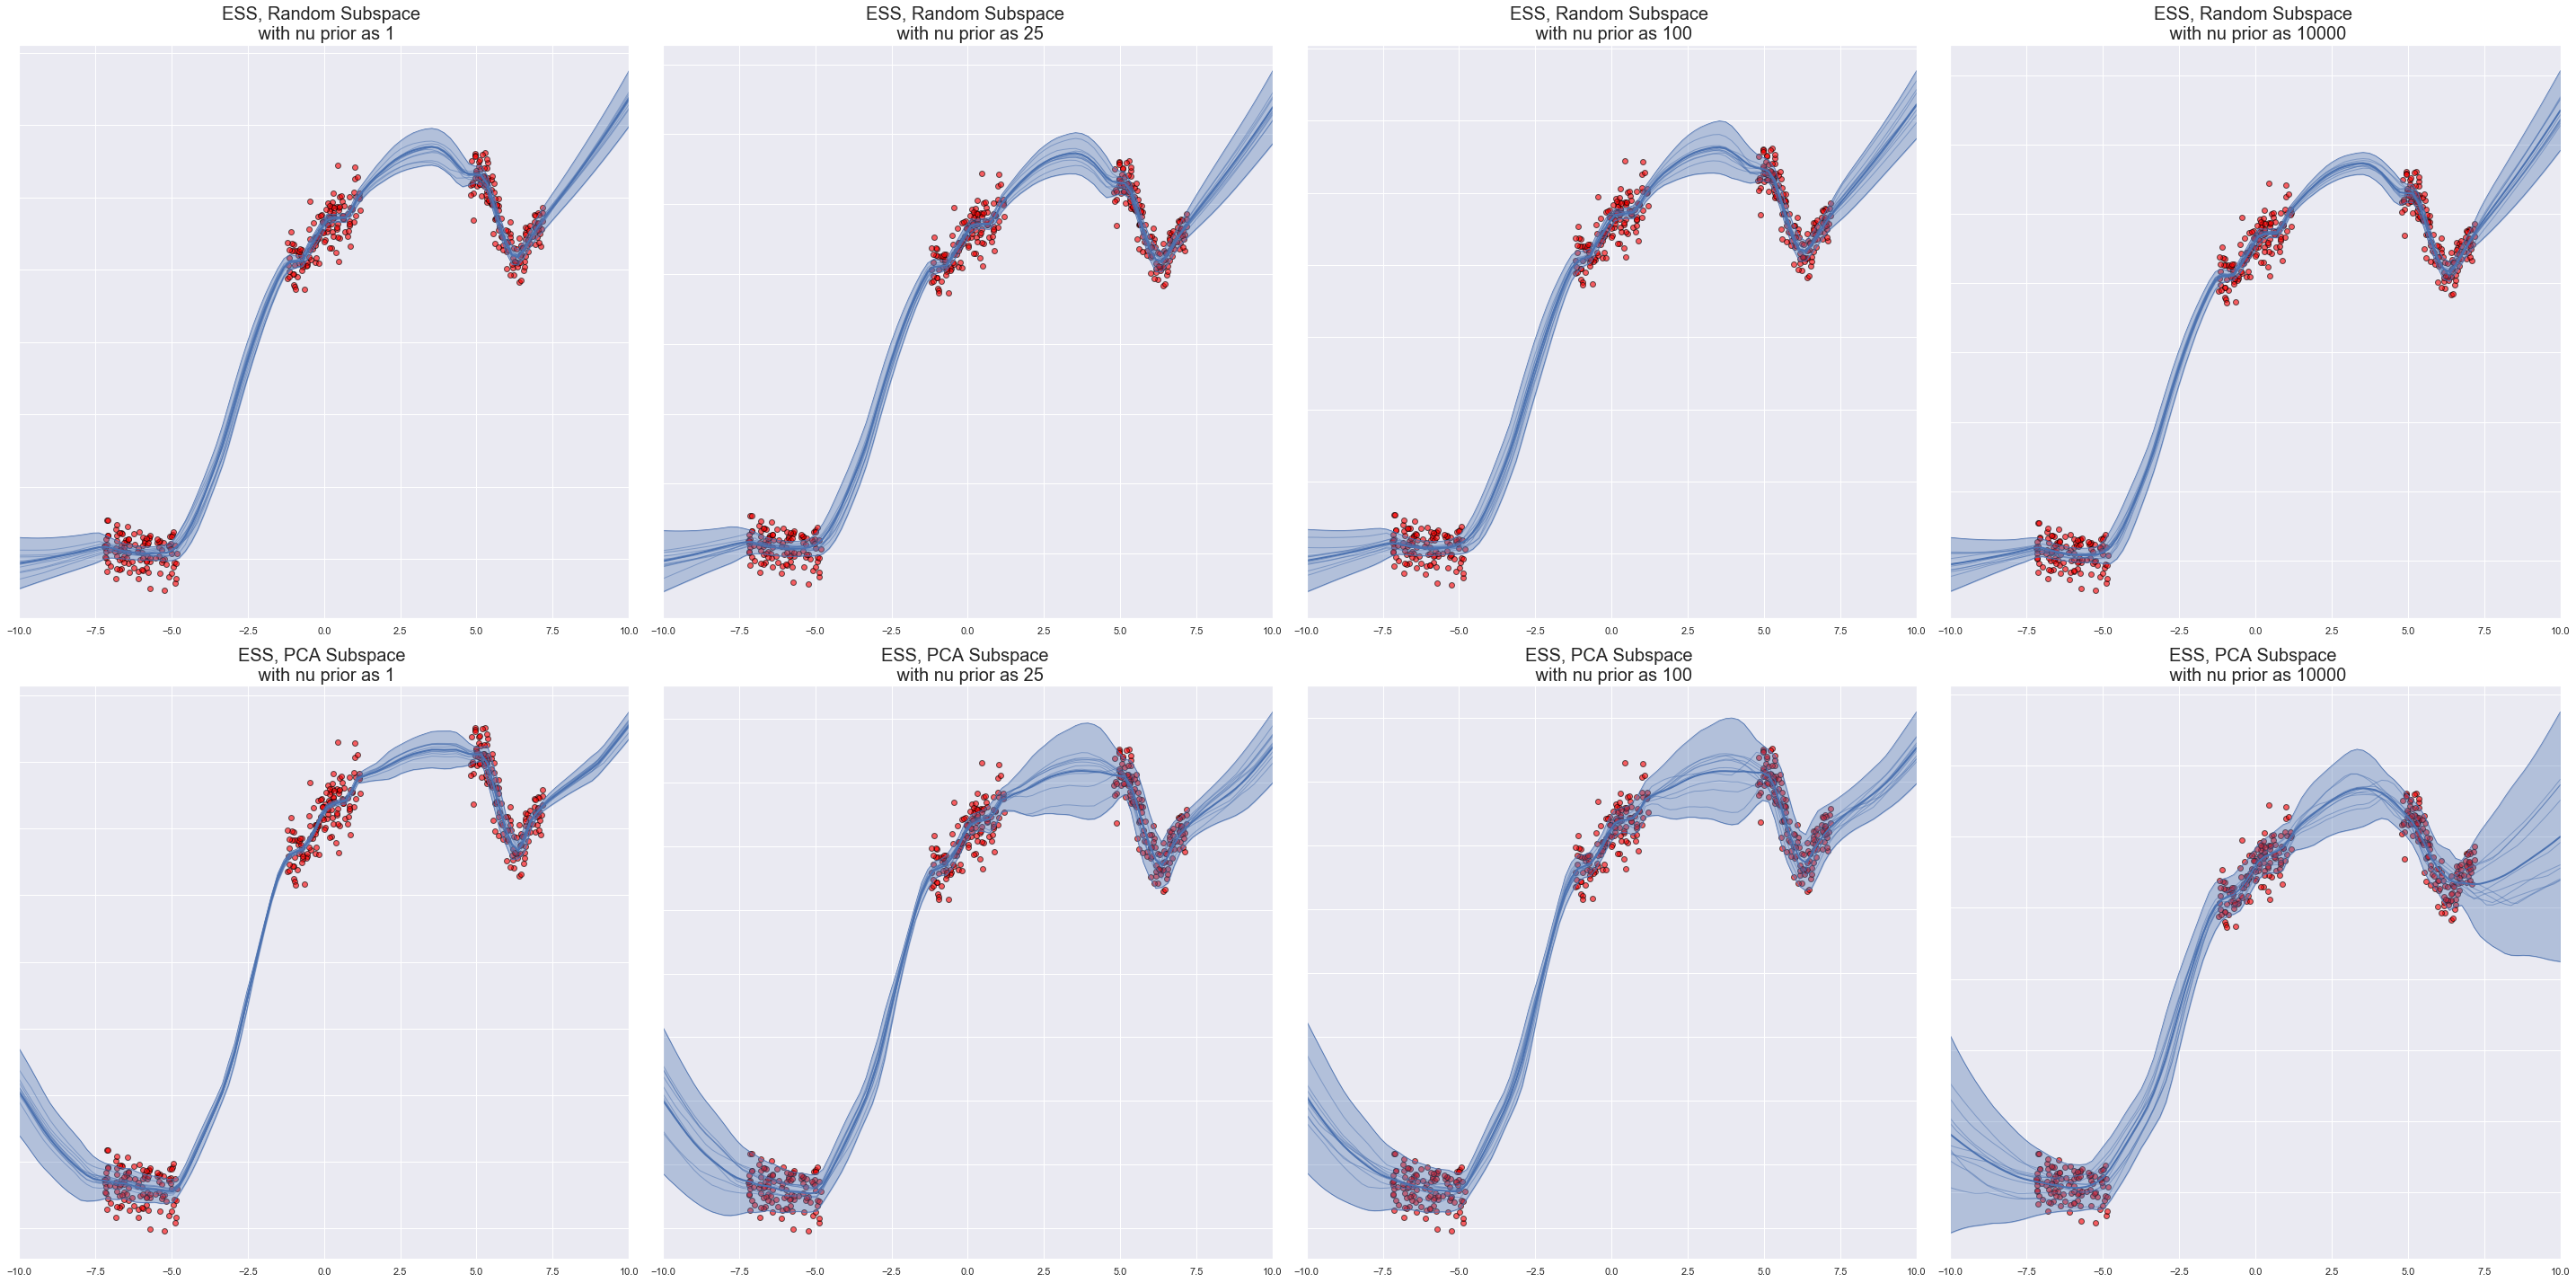

In [18]:
## Putting the plots together for random vs PCA subspace
title = "ESS, {} Subspace \n with nu prior as {}"
fig, ax = plt.subplots(2, 4, figsize = (40,20))
for ix, nu in enumerate(all_nu_scale):
    plot_predictive(data, random_traj_all_nu[ix], z, title=title.format('Random', nu), ax=ax[0,ix])
    plot_predictive(data, pca_traj_all_nu[ix], z, title=title.format('PCA', nu), ax=ax[1,ix])
    
fig.tight_layout()
# fig.savefig('images/nu_scale.png')

Another hyperparameter that we see the authors have set explicitly is the variance used for the prior for $\nu$, in the ESS sampler, $\sigma_{\nu}^2$. The authors used $\sigma_{\nu}^2 = 1$ for random subspace and $\sigma_{\nu}^2 = 25$ for PCA subspace. We experimented with different values of $\sigma_{\nu}^2$ to see how it affected our predictive posterior, keeping all other parameters constant.

Interestingly, we see that for the random subspace, the change in $\sigma_{\nu}^2$ does not affect the uncertainty in the prediction. However, for the PCA subspace, the uncertainty increases, peaks, and then decreases as a function of $\sigma_{\nu}^2$.

<a id='implementation'></a>
### 3.3 HW7 Regression
Next, we extended our implementation to the synthetic data we worked with in HW7 in order to make a direct comparison with the HMC sampler we coded during the semester. Theoretically, if the PCA subspace inference could be carried out successfully on the synthetic regression we have been using up until this point, it would really demonstrate a relevant use case, as we determined that the HMC sampler didn't really converge for even a simple MLP. 

### Preparing the data & fitting a model

In [19]:
import autograd
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import pandas as pd

In [20]:
# Load in data to train MLP
hw7_data = pd.read_csv('data/HW7_data.csv')
hw7_x, hw7_y = hw7_data['x'].values, hw7_data['y'].values

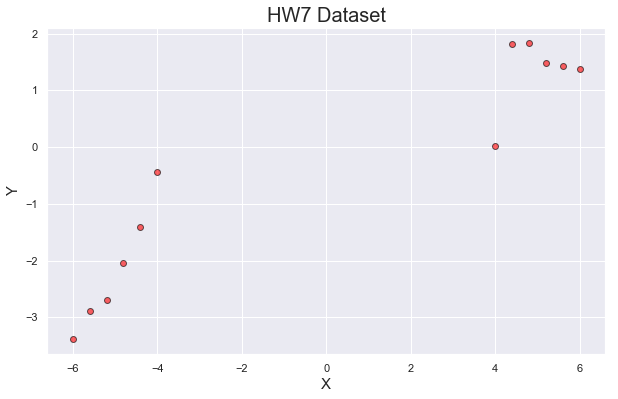

In [21]:
# Visualize data
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(hw7_x, hw7_y, facecolor='red', edgecolor='black', alpha=.6)
ax.set_title('HW7 Dataset', fontsize=20)
ax.set_xlabel('X', fontsize=15)
ax.set_ylabel('Y', fontsize=15);

In [22]:
# Define MLP in pytorch
class MLP2(nn.Module):
    def __init__(self):
        super(MLP2, self).__init__()
        self.fc1 = nn.Linear(1, 10)    # hidden layer 1
        self.fc2 = nn.Linear(10, 10)
        self.output = nn.Linear(10, 1)  # output layer
        
    def forward(self, x):
        x = self.fc1(x).relu()
        x = self.fc2(x).relu()
        return self.output(x)

In [23]:
# Prepare data
hw7_y = hw7_y.reshape(-1, 1)
hw7_x = hw7_x.reshape(-1, 1)
hw7_data = np.vstack((hw7_x.flatten(), hw7_y.flatten())).T
hw7_dataset = TensorDataset(torch.from_numpy(hw7_x.astype(np.float32)), torch.from_numpy(hw7_y.astype(np.float32)))
hw7_dataloader = DataLoader(hw7_dataset, batch_size=50, shuffle=True)

# Define loss function
criterion = get_criterion(loss='MSE')

In [24]:
# Visualize model fit
torch.manual_seed(3)
model = MLP2()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2, momentum=.95)
train_model(model, hw7_dataloader, optimizer, criterion, epochs=3000)

Epoch 0 | LR: 0.01 | Loss: 48.7767
Epoch 1000 | LR: 0.01 | Loss: 0.0800
Epoch 2000 | LR: 0.00603375 | Loss: 0.0514
Epoch 2999 | LR: 0.0005 | Loss: 0.0504



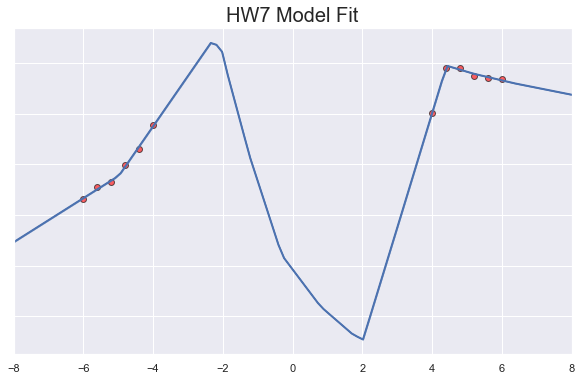

In [25]:
x_test = np.linspace(-8, 8, 100)
y_test = model(torch.tensor(x_test.reshape((-1, 1)).astype(np.float32))).detach().numpy().flatten()
plot_predictive(hw7_data, [y_test], x_test, title="HW7 Model Fit", save_path='images/hw7_model_fit.png')

As can be seen above, the data is scarce in the center of the data range. We expect to see a lot of epistemic uncertainty represented in the Bayesian inference methods to follow.

### Inference w/ ESS & Random Subspace

In [26]:
torch.manual_seed(3)
model = MLP2()
criterion = get_criterion(loss='MSE')
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2, momentum=.95)
model_info = {'model': model, 'dataloader': hw7_dataloader, 'optimizer': optimizer, 'criterion': criterion}
rs = RandomSubspace(model_info, preloaded=None, save=False)

  4%|▍         | 125/3000 [00:00<00:02, 1231.77it/s]

Computing Random Subspace...


100%|██████████| 3000/3000 [00:02<00:00, 1060.71it/s]


In [27]:
# Initialize parameters
T = .15
noise_var = .5
num_samples = 1000

random_ess = ESS(rs, num_samples=num_samples, T=T, noise_var=noise_var, loss_type='MSE')  # initialize sampler with subspace

  1%|          | 11/1000 [00:00<00:11, 82.85it/s]

Initializing 1000 samples...


100%|██████████| 1000/1000 [00:06<00:00, 146.50it/s]


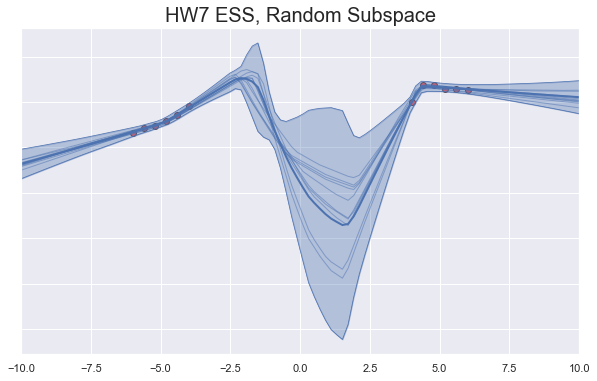

In [28]:
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(z.reshape(-1,1).astype(np.float32))
model = rs.model_info['model']  # pull model from subspace

trajectories = []
for i in range(100):
    # Sample weights using ESS
    weights = random_ess.sample()
    
    # Set model weights
    set_model_weights(model, weights)
    out = model(inp)
    
    trajectories.append(out.detach().numpy().ravel())

trajectories = np.vstack(trajectories)    
plot_predictive(hw7_data, trajectories, z, 
                title="HW7 ESS, Random Subspace", save_path='images/hw7_random_subspace.png')

The random subspace does capture the epistemic uncertainty in the center of the figure. It seems to overshoot the uncertainty range in the areas where data exist slightly, however. 

### Inference w/ ESS & PCA subspace

In [29]:
torch.manual_seed(3)
model = MLP2()
criterion = get_criterion(loss='MSE')
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2, momentum=.95)
model_info = {'model': model, 'dataloader': hw7_dataloader, 'optimizer': optimizer, 'criterion': criterion}
pca_subspace = PCASubspace(model_info, preloaded=None, lr_ratio=.1, save=False)

 12%|█▏        | 367/3000 [00:00<00:01, 1842.47it/s]

Computing PCA Subspace...


100%|██████████| 3000/3000 [00:02<00:00, 1235.16it/s]


In [30]:
# Initialize parameters
num_samples = 1000
T = 1.5
noise_var = .5
nu_scale = 25

ess_pca = ESS(pca_subspace, num_samples=num_samples, T=T, noise_var=noise_var, loss_type='MSE')  # initialize sampler with subspace

  5%|▍         | 49/1000 [00:00<00:01, 488.04it/s]

Initializing 1000 samples...


100%|██████████| 1000/1000 [00:01<00:00, 569.58it/s]


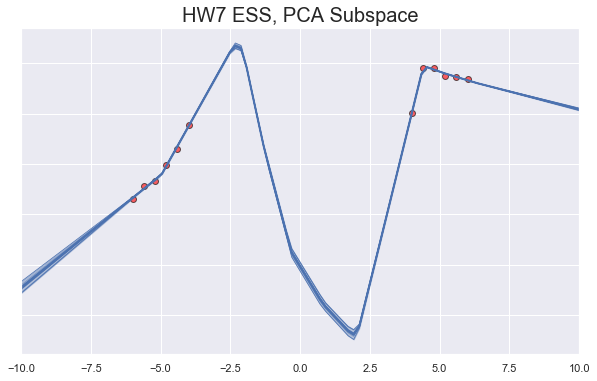

In [31]:
z = np.linspace(-10, 10, 100)
inp = torch.from_numpy(z.reshape(-1,1).astype(np.float32))
model = pca_subspace.model_info['model']  # pull model from subspace

trajectories = []
model.eval()

for i in range(100):
    # Sample weights using ESS
    weights = ess_pca.sample()
    
    # Set model weights
    set_model_weights(model, weights)
    out = model(inp)
    
    trajectories.append(out.detach().numpy().ravel())
trajectories = np.vstack(trajectories) 

plot_predictive(hw7_data, trajectories, z, title="HW7 ESS, PCA Subspace", save_path='images/hw7_pca_subspace.png')

The PCA subspace fails to capture the epistemic uncertainty in the center. We tried the following to improve tune the inference method (to no avail):

1. Modifying the temperature. This seemingly had no effect. Our suspicion is that because there are so few datapoints, the posterior density isn't concentrated around the likelihood, increasing the temperature to stretch the uncertainty interval has no effect. 
2. Increasing the learning rate. We hypothesized that perhaps the SWAG process was limited by a small learning rate (didn't explore enough of the loss function). Howeve, increasing the learning rate only marginally stretched the uncertainty interval, and then when the learning rate got too high, the inference failed completely, and the posterior predictive didn't even fit the data anymore.
3. Decreasing the dimensionality. We though perhaps because the dimensionality of the subspace was similar to the number of datapoints, decreasing the rank would lead to more expressive uncertainty. This, unfortunately, only helped marginally. 
4. Changing $\sigma_{\nu}^2$. This also had a minimal effect on the resulting posterior predictive.

All in all, the PCA subspace did not perform well in this situation, and none of our hypotheses helped the situation. It's very likely that the reason the subspace inference fails here is that not enough of the loss surface is explored during SWAG.

### HMC in the original weight space

In [32]:
# Retrain model to store MLE weights
torch.manual_seed(3)
model = MLP2()

optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2, momentum=.95)
train_model(model, hw7_dataloader, optimizer, criterion, epochs=3000)

model_weights = np.array([])
for value in model.parameters():
    model_weights = np.append(model_weights, value.detach().numpy().flatten())

Epoch 0 | LR: 0.01 | Loss: 48.7767
Epoch 1000 | LR: 0.01 | Loss: 0.0800
Epoch 2000 | LR: 0.00603375 | Loss: 0.0514
Epoch 2999 | LR: 0.0005 | Loss: 0.0504



In [33]:
# Implementation in autograd
def log_joint(w):
    '''computes the log of the posterior given a vector of weights'''
    if type(w) == autograd.numpy.numpy_boxes.ArrayBox:
        set_model_weights(model, torch.from_numpy(w._value))
    else:
        set_model_weights(model, torch.from_numpy(w))
        
    yhat = model(torch.from_numpy(hw7_x.reshape(-1,1).astype(np.float32))).detach().numpy()
    log_p_w = -len(w)/2 * np.log(50*np.pi) - 1/50 * np.dot(w.T, w)     # p(w)
    log_likelihood = -len(hw7_y)/2 * np.log(np.pi/2) - 2*np.sum((hw7_y - yhat)**2)
    
    return log_p_w + log_likelihood

def HMC(H, U, q=0.0, L=50, eps=1e-3, nsamples=int(1e4), burn=.1, thin=10):
    '''Implementation of Hamiltonian Monte Carlo'''
    samples = []
    grad_U = grad(U)
    counter = 0
    for i in tqdm(range(nsamples)):
        # Sample a random momentum from Gibbs p ~ N(0, M)
        p = np.random.normal(0, 1, size=len(q))
        
        # Run the leapfrog algorithm for L steps
        p_t, q_t = p, q
        p_half = p_t - eps/2*grad_U(q_t)
        for l in range(L):
            q_next = q_t + eps*p_half
            p_next = p_half - eps/2*grad_U(q_next)
            
            p_t, q_t = p_next, q_next
        
        # Reverse momentum
        p_t = -p_t
        
        # Implement Metropolis Hastings
        alpha = np.min([1, np.exp(H(q, p) - H(q_t, p_t))])
        test = np.random.uniform(0, 1)
        
        if test <= alpha:  
            samples.append(q_t)  # accept new sample
            q = q_t
            counter += 1
        else:  
            samples.append(q)    # reject and take old sample
            
    # Apply burning and thinning
    burn_ind = int(burn*len(samples))
    samples_thinned = samples[burn_ind::thin]
    print('Acceptance rate: {:.2f}%'.format(counter*100/nsamples))
    
    return samples_thinned, samples

In [34]:
# Define relevant functions and constants
K_nn = lambda p: 1/2*(np.dot(p.T, p) + model_weights.shape[0]*np.log(2*np.pi))
U_nn = lambda q: -log_joint(q)
H_nn = lambda q, p: U_nn(q) + K_nn(p)

In [35]:
# Run sampling
part2_samples, part2_samples_total = HMC(H_nn, U_nn, q=model_weights, 
                                        L=10, eps=1e-2, nsamples=int(1e4), burn=.1, thin=2)


Acceptance rate: 1.19%


In [36]:
## Visualize the posterior predictive
samp_100_ind = np.random.choice(range(len(part2_samples)), size=100, replace=False)
samp_100 = np.array(part2_samples)[samp_100_ind]

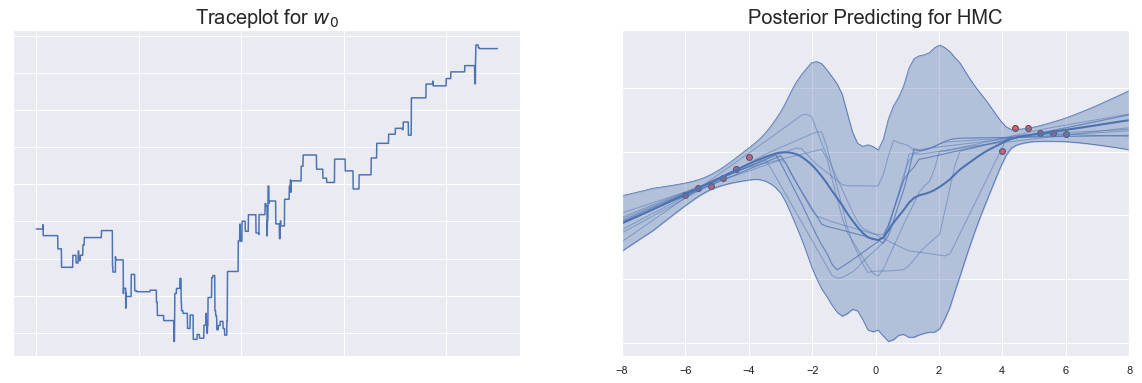

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Trace Plot
axes[0].plot(range(len(part2_samples)), [x[0] for x in part2_samples])
axes[0].set_title('Traceplot for $w_0$', fontsize=20)
axes[0].set_xticklabels([]); axes[0].set_yticklabels([]);

# Posterior Predictive
xs = np.linspace(-8, 8, 100)
ys = []
for i in range(40):
    set_model_weights(model, torch.tensor(samp_100[i].astype(np.float32)))
    ys_temp = model(torch.from_numpy(xs.reshape(-1,1).astype(np.float32))).numpy().flatten()
    ys.append(ys_temp)

plot_predictive(hw7_data, ys, xs, title="Posterior Predicting for HMC", 
                save_path='images/hw7_HMC.png', ax=axes[1])

While the traceplot reveals that the HMC sampler has by no means converged, it does a really good job representing the epistemic uncertainty in the center of the figure. As such, we didn't see a substantial gain from using subspace inference as opposed to HMC in the original weight space, aside from the fact that the subspace inference was computationally faster. 

It's possible that our network was not complicated enough for there to be an advantage to dimensionality reduction, or that we didn't tune the subspace inference methods properly. If the latter is true, then this is indicative of a greater issue in performing subspace inference, as there are a surprising number of parameters to keep track of, as we will elaborate on in the discussion.

<hr style="height:3pt">

## 4. Discussion

<hr style="height:3pt">

### 4.1 Reproducibility
While we were trying to replicate the experiment ran by the authors on the synthetic data, we noted a couple key discrepancies in their implementation hosted on GitHub compared to their paper. In all instances where their code contradicted their writing, we went with their code:
 
1.	We found an inconsistency in calculation of $a_i$. The code on GitHub shows $w_{SWA} – w_i$ while the paper shows $w_i - w_{SWA}$ in the main algorithm. We weren't sure if this was a substantial difference, but went with what they did in their code, as it also matched the approach in a reference they linked.


2.	In the subspace construction with the PCA implementation, we needed to perform PCA on the deviance matrix $A$. While the paper instructed the reader to perform PCA on the $A$ matrix, in their code they performed PCA on $A/\sqrt{(k-1)}$. We were very confused by this. What's worse, we tried excluding the factor in front of $A$, and it made our results much worse for PCA (a.k.a, it does matter). We hypothesize that this factor may stem from the SWAG paper (https://arxiv.org/pdf/1902.02476.pdf), where a similar factor appears in the covariance term for the Gaussian approximation to the posterior. Even still, this isn't an exact match.


3. The authors specified in the paper that they used $M = 20$ as number of SGD iterations for which to accumulate the deviations $a_i$. However, on their GitHub implementation, $M$ is 10,000.

### 4.2 Parameter mayhem
There were tons of choices to make in order to get the subspace inference working as expected. Below is a non-exhaustive list of all the major ones:

- Network training for SWAG: As a part of SWAG, a neural network gets trained. Therefore, one must consider: 
    - architecture
        - number of hidden layers & nodes
    - optimizer
        - learning rate & decay schedule
    - loss function
    - batch_size
    - epochs
    - when SWAG should begin

- Dimensionality of the subspace, $K$
- Temperature, $T$
- The variance of the response variable, $\sigma_{y}^2$
- The scale factor applied to the covariance term of the $\nu$ parameter in ESS sampling, $\sigma_{\nu}^2$
- The number of samples to take during inference, and the fraction of these samples to keep
- The number of iterations to run the SVD for the PCA subspace method

Most of these choices are non-intuitive and we based our decisions heavily upon the choice made by the original authors of the paper, though we did play around with a number of these parameters to examine their effects on the performance, as we've reported above.

### 4.3 Conclusions about the Rigor & Generalizability of the Paper
While initially promising, ultimately we've concluded that we weren't able to completely replicate the paper's results for two reasons: 

- First, even after using their exact parameters and model weights, we weren't able to exactly reproduce the ESS random/PCA posterior predictives that they include in Figure 3 of their paper (our results were similar, but there were characteristic disparities, such as the fanning out of the uncertainty for $x > 7.5$). 
- Second, while the authors touted the efficacy of the PCA method, we couldn't extend it to a very similar problem, even after trying every diagnostic up our sleeves. 

The authors also applied subspace inference on larger-scale datasets, including CIFAR-100 and a few large UCI regression datasets. We did not try to replicate these experiments, so we still think that the results shown in the paper were promising, as larger networks could be more demonstrative of the benefits of subspace inference.

### Citations 

<a id='cit1'></a>
**Maddox, W., Garipov, T., Izmailov, P., Vetrov, D., and Wilson, A. G.** (2019). *A simple baseline for bayesian uncertainty in deep learning.* arXiv preprint arXiv:1902.02476.

<a id='cit2'></a>
**Murray, I., Prescott Adams, R., and MacKay, D. J.** (2010). *Elliptical slice sampling.* In Artificial Intelligence and Statistics.

<a id='cit3'></a>
**Silva, R. and Kalaitzis, A.** (2015). *Bayesian inference via projections.* Statistics and Computing, 25(4):739–753.

<a id='cit4'></a>
**Pradier, M. F., Pan, W., Yao, J., Ghosh, S., and Doshi- velez, F.** (2018). *Projected BNNs: Avoiding weight- space pathologies by learning latent representations of neural network weights.* arXiv preprints, page arXiv:1811.07006.

<a id='cit5'></a>
**Huggins, J., Campbell, T., and Broderick, T.** (2016). *Coresets for scalable bayesian logistic regression.* In Advances in Neural Information Processing Systems, pages 4080–4088.